In [2]:
%load_ext autoreload
%autoreload 2

import sys
# change this to suit your path
sys.path.append('/home/guillaume/Python/kt_simul/')
from kt_simul.smp_spindle.smp_spindle import SympySpindle, parameters


import IPython.display as disp
import os

### Visualisation using openscad

This has the advangtage of being simple to use

```python
import solid as solid
import tempfile
solid.use('spindle.scad')
spindle_length = 4
ch_pos = [-0.4, 0.1, 1]
stretch = 0.3
ch_theta = 30
ch_phi = 10

scad_spindle = (spindle_midzone(spindle_length) +
                chromosome(ch_pos, stretch, ch_theta, ch_phi))
def show_scad(scad_spindle, img_name='spindle_scad.png'):
    if os.path.isfile(img_name):
        os.remove(img_name)
    with tempfile.NamedTemporaryFile('w', suffix='.scad') as tmp_scad:
        solid.scad_render_to_file(scad_spindle, tmp_scad.name)
        os.system('openscad -o {} {}'.format(img_name, tmp_scad.name))
    return disp.Image(img_name)
show_scad(scad_spindle)
```

In [7]:
import vispy.geometry as vp_geom
import vispy.util as vp_util

def translate(mesh, pos):
    
    mesh.set_vertices(mesh.get_vertices() + pos)
    return mesh
    

def create_spb(pos, radius=0.3):
    spb = vp_geom.create_sphere(12, 12, radius)
    return translate(spb, pos)
    
    
def create_midzone(length, r=0.2):
    
    mz = vp_geom.create_cylinder(12, 2, [r, r],
                                 length, True)
    return mz
    
def create_chromosome(stretch, orientation, r=0.1):
    
    theta, phi, omega = orientation
    
    ch = vp_geom.create_cylinder(12, 2, [r, r],
                                 length, True)
    
### Maybe scene visuals is better suited, see:
### http://api.vispy.org/en/latest/scene.html

from vispy import app, gloo, visuals
from vispy.visuals.transforms import (STTransform, AffineTransform,
                                      ChainTransform)


class Canvas(app.Canvas):
    def __init__(self, mdatas):
        app.Canvas.__init__(self, keys='interactive', size=(800, 550))

        self.rotation = AffineTransform()
        self.meshes = [visuals.MeshVisual(meshdata=mdata, color='r') for mdata in mdatas]

        self.show()

        self.timer = app.Timer(connect=self.rotate)
        self.timer.start(0.016)

    def rotate(self, event):
        self.rotation.rotate(1, (0, 1, 0))
        self.update()

    def on_draw(self, ev):
        gloo.set_viewport(0, 0, *self.physical_size)
        gloo.clear(color='black', depth=True)
        for mesh in self.meshes:
            mesh.draw()

length = 3.

            
spbL = create_spb([-length/2, 0, 0])
spbR = create_spb([length/2, 0, 0])
mz = create_midzone(length)

#win = Canvas([spbL, spbR, mz])
#import sys
#if sys.flags.interactive != 1:
#    app.run()

### Too be continued    



### Model description

We're looking at a simple mechanical system

![3D spindle](3d_spindle.svg)



#### Points and coordiantes

Point is the physical location of an element.

In the method we use to write the equations of motion of the system, we use what is caled **generalized coordinates** and **generalized speeds**. The generic letter for a gen. coordinate is **q** and **u** for the speeds. Those are the quantities marked in red on the sketch.

As a starting point to a 3D description of the spindle, 




### Parameters 

In [34]:
## Those are simple  `sympy.symbols`
for param in parameters.keys():
    print(param)
    

d_0
mu_c
kappa_k
V_k
mu_k
F_mz
mu_ch
mu_s
F_k
kappa_c
V_mz


## Spindle class instanciation



In [35]:
spindle = SympySpindle('1D_1_1', N=3, Mk=3)

In [36]:
spindle.chromosomes[0].centromeres

In [ ]:
spindle.S.orientnew()

In [5]:
cen_A00 = spindle.points[3]

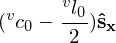

In [6]:
cen_A00.vel(spindle.S)

In [7]:
spbR = spindle.points[0]

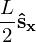

In [8]:
spbR.pos_from(spindle.center)

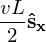

In [9]:
spbR.vel(spindle.S)

In [10]:
spindle.kanesmethod()

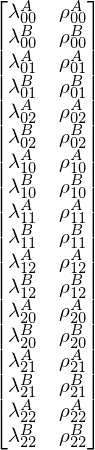

In [11]:
spindle.attach_state

In [12]:
import sympy as sy

In [15]:
null_state = sy.zeros(*spindle.attach_state.shape)
amphitelic_state = null_state.copy()
## Bug??
amphitelic_state[::2, 0] = sy.ones(spindle.N * spindle.Mk, 1)
amphitelic_state[1::2, 1] = sy.ones(spindle.N * spindle.Mk, 1)

ShapeError: 
The Matrix `value` doesn't have the same dimensions as the in sub-
Matrix given by `key`.

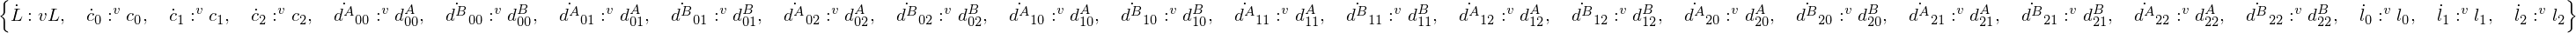

In [17]:
spindle.KM.kindiffdict()

In [19]:
parameters

{'F_k': F_k,
 'F_mz': F_mz,
 'V_k': V_k,
 'V_mz': V_mz,
 'd_0': d_0,
 'kappa_c': kappa_c,
 'kappa_k': kappa_k,
 'mu_c': mu_c,
 'mu_ch': mu_ch,
 'mu_k': mu_k,
 'mu_s': mu_s}

In [20]:
passive_params = ['mu_s', 'mu_ch', 'mu_c','mu_k',
                  'kappa_c', 'kappa_k', 'd_0']
passive_zero = {parameters[name]:0 for name in passive_params}

active_params = ['F_k', 'V_k', 'F_mz', 'V_mz']
active_zero = {parameters[name]:0 for name in active_params}

adim = {parameters['F_k']:1, parameters['V_k']:1}

In [25]:
ch.id

In [24]:
ch.cen_A.ref = ch.ref.orientnew('C_{}'.format(ch.id),
                                


S

In [ ]:
ch.ref = spindle.S.orientnew

In [18]:
A0 = spindle.A_uu.subs(active_zero)

In [19]:
At = spindle.A_uu.subs(passive_zero)

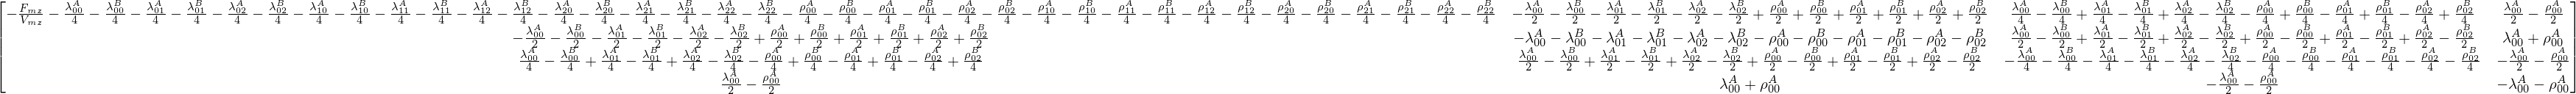

In [24]:
At.subs(adim)[:4, :4]

In [36]:
parameters['mu_s']

In [51]:
0

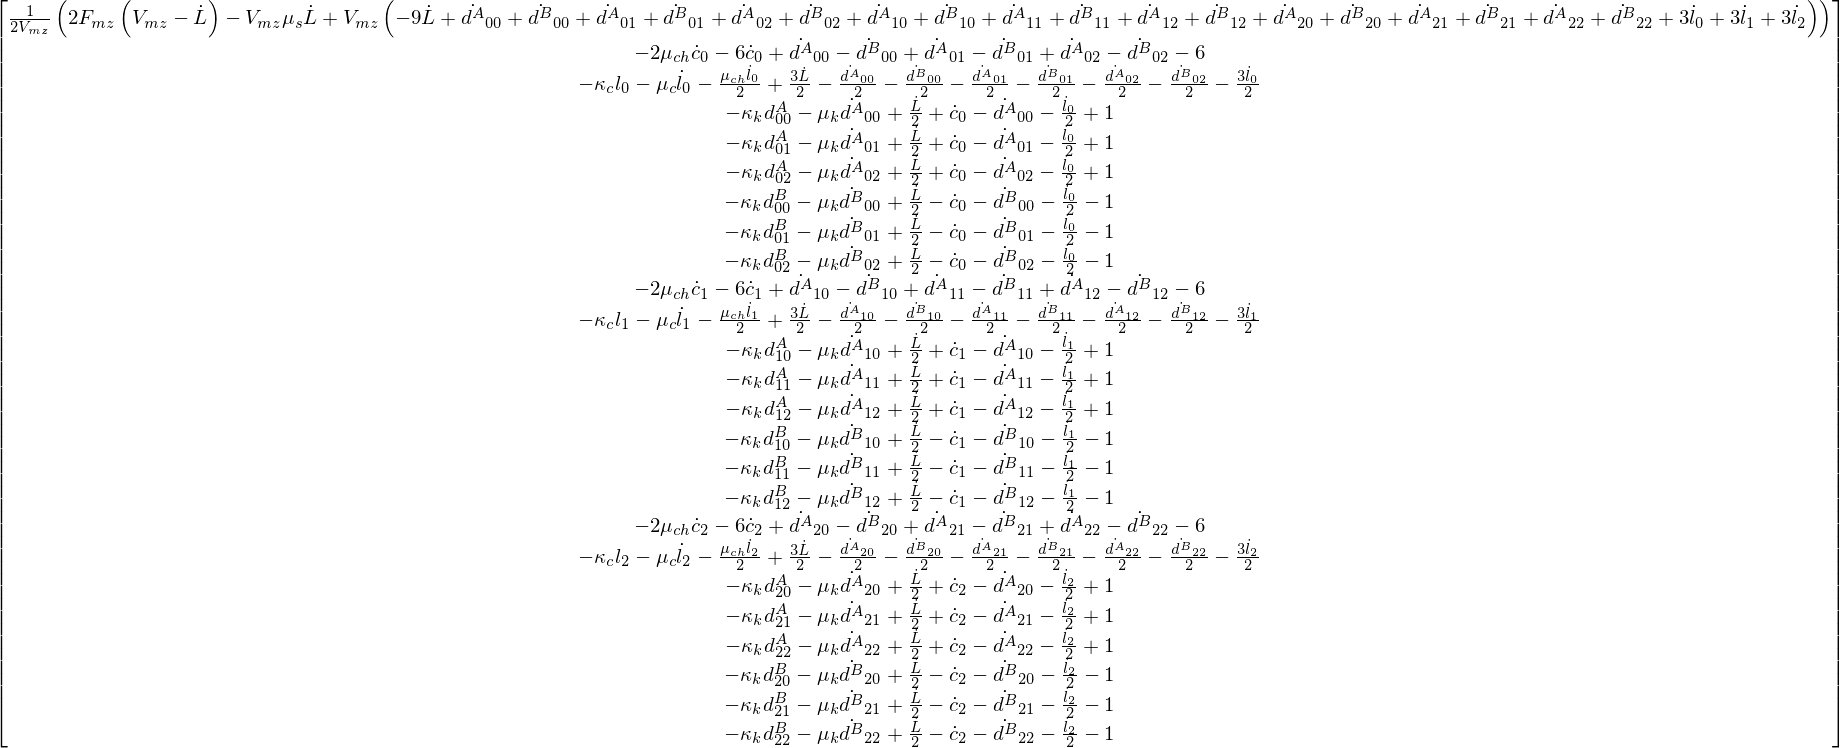

In [11]:
eoms.simplify()
rev_kddict = {v:k for k, v in spindle.KM.kindiffdict().items()}
eoms.subs(rev_kddict).subs(adim)

In [11]:
spindle.points


[spbR,
 spbL,
 ch_0,
 cen_0^A,
 as_00^A,
 as_01^A,
 as_02^A,
 cen_0^B,
 as_00^B,
 as_01^B,
 as_02^B,
 ch_1,
 cen_1^A,
 as_10^A,
 as_11^A,
 as_12^A,
 cen_1^B,
 as_10^B,
 as_11^B,
 as_12^B,
 ch_2,
 cen_2^A,
 as_20^A,
 as_21^A,
 as_22^A,
 cen_2^B,
 as_20^B,
 as_21^B,
 as_22^B]

In [12]:
spindle.q_ind

In [3]:
A_uu_adim = spindle.A_uu.subs(subs).subs({parameters['F_k']:1, parameters['V_k']:1})

NameError: name 'spindle' is not defined

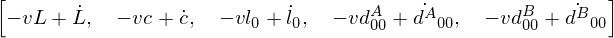

In [12]:
spindle.kd

In [10]:
spindle.u_ind


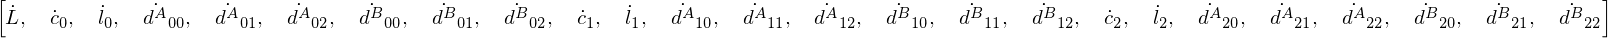

In [14]:
spindle.qd_ind

In [8]:
spindle.forces

[(spbR, - mu_s*vL/2*S.x),
 (spbL, mu_s*vL/2*S.x),
 (spbL, - F_mz*(1 - vL/V_mz)*S.x),
 (spbR, F_mz*(1 - vL/V_mz)*S.x),
 (cen_0^A, mu_ch*vl_0/2*S.x),
 (cen_0^A, - kappa_k*d_00^A*S.x),
 (as_00^A, kappa_k*d_00^A*S.x),
 (cen_0^A, - mu_k*d_00^A*S.x),
 (as_00^A, mu_k*d_00^A*S.x),
 (spbL, F_k*lambda_00^A*(1 - (d_00^A - vL/2 + vl_0/2)/V_k)*S.x),
 (as_00^A, - F_k*lambda_00^A*(1 - (d_00^A - vL/2 + vl_0/2)/V_k)*S.x),
 (as_00^A, F_k*rho_00^A*(-1 - (-d_00^A - vL/2 - vl_0/2)/V_k)*S.x),
 (spbR, - F_k*rho_00^A*(-1 - (-d_00^A - vL/2 - vl_0/2)/V_k)*S.x),
 (cen_0^B, - mu_ch*vl_0/2*S.x),
 (cen_0^B, kappa_k*d_00^B*S.x),
 (as_00^B, - kappa_k*d_00^B*S.x),
 (cen_0^B, mu_k*d_00^B*S.x),
 (as_00^B, - mu_k*d_00^B*S.x),
 (spbL, F_k*lambda_00^B*(1 - (-d_00^B - vL/2 - vl_0/2)/V_k)*S.x),
 (as_00^B, - F_k*lambda_00^B*(1 - (-d_00^B - vL/2 - vl_0/2)/V_k)*S.x),
 (as_00^B, F_k*rho_00^B*(-1 - (d_00^B - vL/2 + vl_0/2)/V_k)*S.x),
 (spbR, - F_k*rho_00^B*(-1 - (d_00^B - vL/2 + vl_0/2)/V_k)*S.x),
 (cen_0^A, kappa_c*l_0*S.x),
 (c